In [1]:
import math

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
from datetime import datetime

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from binance.client import Client

In [2]:
client = Client('JLCON0ZJ9v4zX595o2W1rlvSIhIercTu2ugNLCMPZ88QAt8zvSe2vY3LDiiRjKMB','JMnozKSUlep8mBrXCW1b7mAdHDl5qcYv3GDfNOquyifCdbD4QmGXILR9A5V0FgKf')
start_str = 'Jan 1, 2021'
end_str = ''
coin = 'BNB'
klines = client.get_historical_klines(symbol=f'{coin}USDT', interval=client.KLINE_INTERVAL_1DAY, start_str=start_str)
df = pd.DataFrame(klines)
df = df.iloc[:,:6]
df.columns = ['time','open','high','low','close','volume']
df = df.astype(float)
df['time'] = [datetime.fromtimestamp(ts / 1000) for ts in df['time']]

df.tail()

,time,open,high,low,close,volume
699,2022-12-01 07:00:00,300.6,302.0,290.0,292.3,798867.735
700,2022-12-02 07:00:00,292.3,293.9,285.4,293.4,364102.285
701,2022-12-03 07:00:00,293.4,294.4,289.0,290.4,234377.055
702,2022-12-04 07:00:00,290.4,292.8,287.4,291.8,244356.783
703,2022-12-05 07:00:00,291.8,296.7,291.4,294.8,56305.683


In [12]:

open = df['open']
high = df['high']
low  = df['low']
close = df['close']
volume = df['volume']
df.dropna()
avg = (df['high'] + df['low']) / 2

df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['BBANDS_upperband'] = (df['BBANDS_upperband'] - avg) / close
df['BBANDS_middleband'] = (df['BBANDS_middleband'] - avg) / close
df['BBANDS_lowerband'] = (df['BBANDS_lowerband'] - avg) / close
df['DEMA'] = (talib.DEMA(close, timeperiod=30) - avg) / close
df['EMA'] = (talib.EMA(close, timeperiod=30) - avg) / close
df['HT_TRENDLINE'] = (talib.HT_TRENDLINE(close) - avg) / close
df['KAMA'] = (talib.KAMA(close, timeperiod=30) - avg) / close
df['MA'] = (talib.MA(close, timeperiod=30, matype=0) - avg) / close
df['MIDPOINT'] = (talib.MIDPOINT(close, timeperiod=14) - avg) / close
df['SMA'] = (talib.SMA(close, timeperiod=30) - avg) / close
df['T3'] = (talib.T3(close, timeperiod=5, vfactor=0) - avg) / close
df['TEMA'] = (talib.TEMA(close, timeperiod=30) - avg) / close
df['TRIMA'] = (talib.TRIMA(close, timeperiod=30) - avg) / close
df['WMA'] = (talib.WMA(close, timeperiod=30) - avg) / close
df['LINEARREG'] = (talib.LINEARREG(close, timeperiod=14) - close) / close
df['LINEARREG_INTERCEPT'] = (talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close) / close



df['AD'] = talib.AD(high, low, close, volume) / close
df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10) / close
df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0) / close
df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
df['HT_PHASOR_inphase'] /= close
df['HT_PHASOR_quadrature'] /= close
df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14) / close
df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD_macd'] /= close
df['MACD_macdsignal'] /= close
df['MACD_macdhist'] /= close
df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14) / close
df['MOM'] = talib.MOM(close, timeperiod=10) / close
df['OBV'] = talib.OBV(close, volume) / close
df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14) / close
df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1) / close
df['TRANGE'] = talib.TRANGE(high, low, close) / close


df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
df['BOP'] = talib.BOP(open, high, low, close)
df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
df['DX'] = talib.DX(high, low, close, timeperiod=14)
    # skip MACDEXT MACDFIX
df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
df['RSI'] = talib.RSI(close, timeperiod=14)
df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
df['TRIX'] = talib.TRIX(close, timeperiod=30)
df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

df['ATR'] = talib.ATR(high, low, close, timeperiod=14)  # Chỉ báo về biên động thị trường
df['NATR'] = talib.NATR(high, low, close, timeperiod=14)

df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

df['BETA'] = talib.BETA(high, low, timeperiod=5)
df['CORREL'] = talib.CORREL(high, low, timeperiod=30)

df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)

df['MARUBOZU'] = talib.CDLMARUBOZU(open,high,low,close)
df['HAMMER'] = talib.CDLHAMMER(open,high,low,close)
df['DOJI'] = talib.CDLDOJI(open,high,low,close)
display(df)
df.to_csv('data.csv')
# df.to_pickle('df_ft.pkl')


,time,open,high,low,close,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,y_sell,buy_cost,sell_cost,y_pred_buy,y_pred_sell,cum_ret,poss,MARUBOZU,HAMMER,DOJI
176,2021-06-26 07:00:00,280.89,290.33,264.26,279.65,2.263064e+06,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000342,0.019021,0.000000,0.0,0,0,0
177,2021-06-27 07:00:00,279.58,291.70,269.72,290.87,1.539903e+06,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,-0.009721,0.003050,0.000000,0.0,0,0,0
178,2021-06-28 07:00:00,290.89,299.96,283.55,290.00,1.884580e+06,NaN,NaN,NaN,NaN,...,0.081981,0.000000,-0.069166,0.011105,0.013539,0.031959,-1.0,0,0,0
179,2021-06-29 07:00:00,290.00,315.60,289.19,300.79,2.126079e+06,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,-0.007592,0.021041,0.022251,-1.0,0,0,0
180,2021-06-30 07:00:00,300.79,304.88,281.53,303.71,2.061866e+06,0.055768,-0.000662,-0.057091,NaN,...,0.000000,-0.062760,0.000000,0.017894,-0.003745,0.094166,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,2022-11-23 07:00:00,266.80,301.80,264.80,298.80,1.224051e+06,0.060363,-0.040361,-0.141086,-0.004133,...,0.000000,0.000000,0.000000,-0.012584,-0.004196,0.764044,-1.0,0,0,0
692,2022-11-24 07:00:00,298.90,304.10,293.90,300.20,5.507927e+05,0.052909,-0.074084,-0.201077,-0.049795,...,0.000000,0.000000,0.000000,-0.023507,-0.004955,0.762045,-1.0,0,0,100
693,2022-11-25 07:00:00,300.30,306.60,294.10,300.80,4.657335e+05,0.077855,-0.054089,-0.186033,-0.047931,...,0.036552,0.000000,-0.030120,-0.005897,0.000424,0.726806,-1.0,0,0,100
694,2022-11-26 07:00:00,300.80,317.80,299.90,311.40,5.695788e+05,0.054505,-0.042614,-0.139733,-0.063861,...,0.000000,0.000000,0.000000,0.034038,0.013731,0.739009,-1.0,0,0,0


Trực quan khoảng thời gian giữ lệnh 


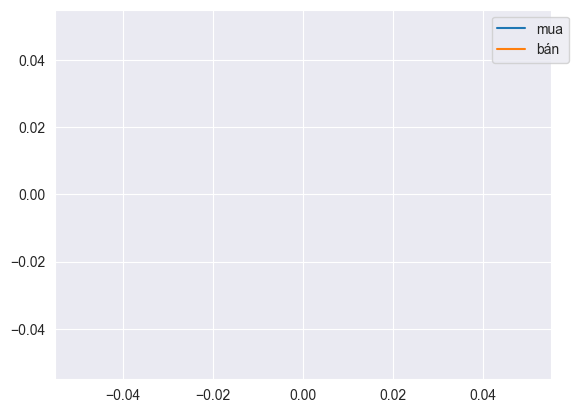

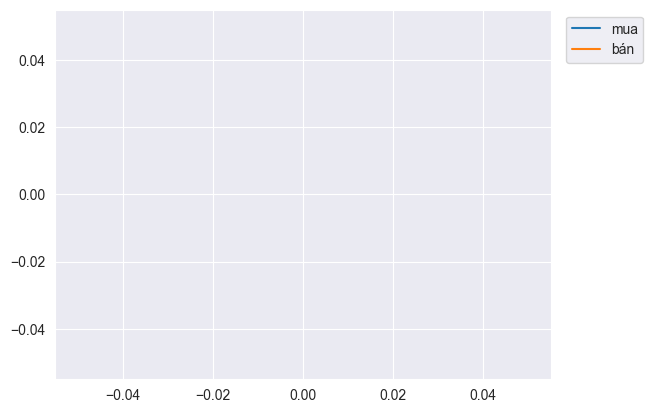

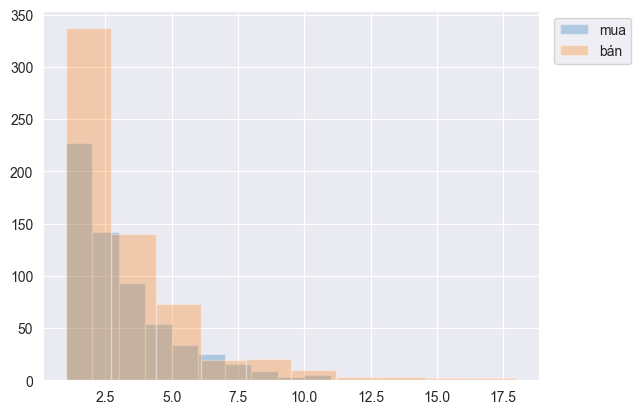

Lợi nhuận tích lũy


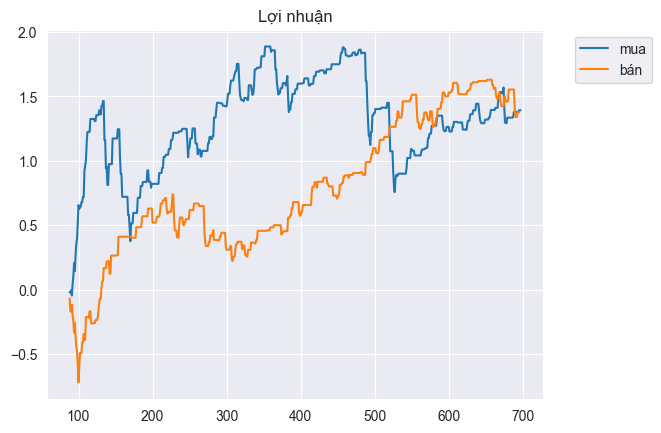

In [4]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_ft.pkl')


pips = 1

# ATR
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# limit_price_dist 2 bên giá
df['buy_price'] = df['close'] - limit_price_dist
df['sell_price'] = df['close'] + limit_price_dist

# Force Entry Price
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['low'].values,
    pips=pips,
)

# calc_force_entry_price
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['high'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # thời gian chờ
fee = -0.0002

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['low'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['high'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['close'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['close'] - 1) + fee,
    0
)
df['buy_fet'].hist(alpha=0.3, label='mua')
df['sell_fet'].hist(alpha=0.3, label='bán')
plt.title('')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('Lợi nhuận tích lũy')
df['y_buy'].cumsum().plot(label='mua')
df['y_sell'].cumsum().plot(label='bán')
plt.title('Lợi nhuận')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')


In [5]:
### Traing Model

In [6]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
    'MOM',
     'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',

    'ULTOSC',
    'WILLR',

    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

Lợi nhuận có khi y_pred Dương trong mỗi giờ 


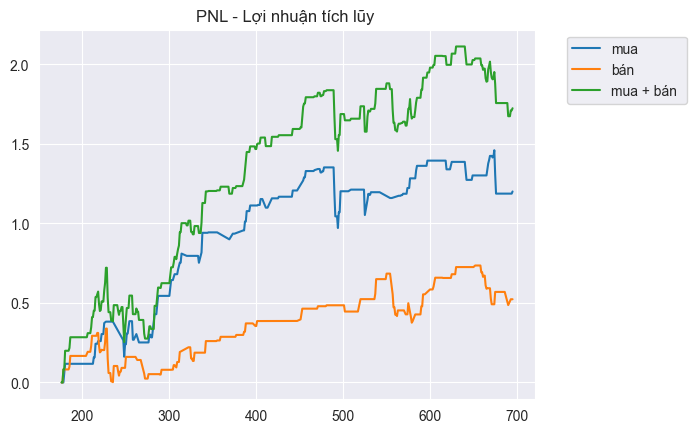

In [7]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)


model.fit(df[features], df['y_buy'])
joblib.dump(model, 'model_y_buy.xz', compress=True)
model.fit(df[features], df['y_sell'])
joblib.dump(model, 'model_y_sell.xz', compress=True)

cv_indicies = list(KFold().split(df))

def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)


df = df.dropna()

print('Lợi nhuận có khi y_pred Dương trong mỗi giờ ')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='mua')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='bán')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='mua + bán ')
plt.title('PNL - Lợi nhuận tích lũy ')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_fit.pkl')

In [8]:
###BackTest

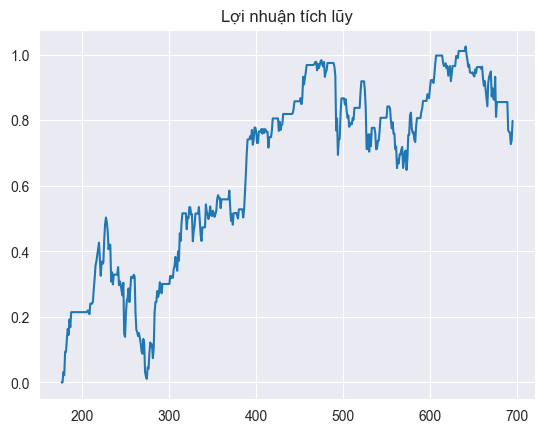

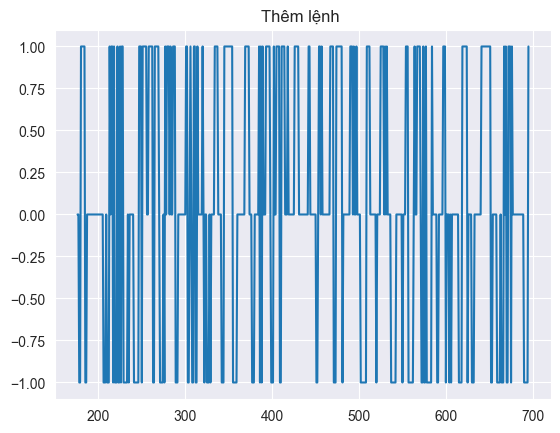

Chuyển đổi xu thế 


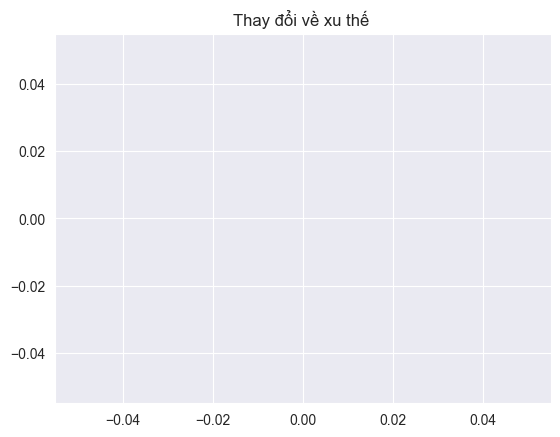

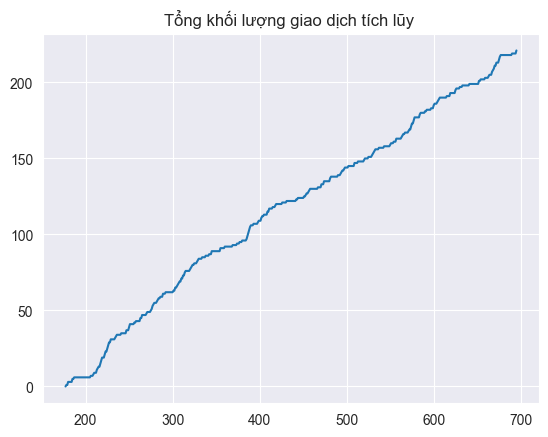

t 1.1855242332671576
p 0.23635379129591585
p mean n = 5
p mean 0.5854780753087548
Tỉ lệ lỗi  1.791521225639932


C:\Users\DAD\AppData\Local\Temp\ipykernel_18060\221958046.py:84: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  x2 = x[i * x.size // n:(i + 1) * x.size // n]


In [9]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
             buy_entry=None, sell_entry=None,
             buy_cost=None, sell_cost=None
             ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos

        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol

        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)

        y[i] = ret
        poss[i] = pos

    return y, poss

df = pd.read_pickle('df_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['close'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot()
plt.title('Lợi nhuận tích lũy')
plt.show()


df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('Tổng khối lượng giao dịch tích lũy ')
plt.show()


x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t {}'.format(t))
print('p {}'.format(p))


def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p mean n = {}'.format(p_mean_n))
print('p mean {}'.format(p_mean))
print('Tỉ lệ lỗi  {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


In [11]:
class TradingEnv:
    def __init__(self, balance_amount, balance_unit, trading_fee_multiplier, symbols):
        self.balance_amount = balance_amount
        self.balance_unit = balance_unit
        self.buys = []
        self.sells = []
        self.trading_fee_multiplier = trading_fee_multiplier
        self.symbols = symbols

        self.bottoms = {}
        self.reset_bottoms()

        self.tops = {}
        self.reset_tops()

    def buy(self, symbol, buy_price, time):
        self.balance_amount = (self.balance_amount / buy_price) * self.trading_fee_multiplier
        self.balance_unit = symbol
        self.buys.append([symbol, time, buy_price])

    def sell(self, sell_price, time):
        self.balance_amount = self.balance_amount * sell_price * self.trading_fee_multiplier
        self.sells.append( [self.balance_unit, time, sell_price] )
        self.balance_unit = 'USDT'

    def reset_bottoms(self):
        for symbol in self.symbols:
            self.bottoms[symbol] = 'none'

    def reset_tops(self):
        for symbol in self.symbols:
            self.tops[symbol] = 'none'

In [10]:
env = TradingEnv(balance_amount=100,balance_unit='USDT', trading_fee_multiplier=0.99925, symbols='BTCUSD')




